In [2]:
import glob
import logging
import random
import time
import gc

import numpy as np
import matplotlib.pyplot as plt

import cv2
import torchstain

import torch
from torch.utils.data import DataLoader
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2


from patch_dataset import PatchDataset
from class_mapping import NAME2TYPELABELS_MAP, NAME2SUBTYPELABELS_MAP, LABELS2TYPE_MAP, LABELS2SUBTYPE_MAP
from train_utils import run_train_loop, seed_worker, plot_history
from log_utils import setup_logging

In [3]:
setup_logging()

2023-08-20 14:23:48,639-INFO-Logging setup complete.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"pytorch device using: {device}")

2023-08-20 14:23:48,925-INFO-pytorch device using: cuda


In [5]:
MAGNIFICATION = "20x"
COLOR_SPACE = "RGB"
CLASS_MAP = NAME2TYPELABELS_MAP
LABEL_MAP = LABELS2TYPE_MAP

PATCH_PATH = "./data/roi_patches"

# relative to script execution path
OUTPUT_PLOT_PATH = "./output/plots"
MODEL_SAVEPATH = "./models"

In [6]:
# load dataset
train_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/train/**/*-{MAGNIFICATION}"))

train_img_path = []
train_mask_path = []

for roi in train_patches_paths:
    train_img_path.extend(glob.glob(roi + "/patch/*.png"))
    train_mask_path.extend(glob.glob(roi + "/mask/*.png"))

train_img_path.sort()
train_mask_path.sort()

assert len(train_img_path) == len(train_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} train images: {len(train_img_path)}")

val_patches_paths = sorted(glob.glob(f"{PATCH_PATH}/val/**/*-{MAGNIFICATION}"))

val_img_path = []
val_mask_path = []

for roi in val_patches_paths:
    val_img_path.extend(glob.glob(roi + "/patch/*.png"))
    val_mask_path.extend(glob.glob(roi + "/mask/*.png"))

val_img_path.sort()
val_mask_path.sort()

assert len(val_img_path) == len(val_mask_path), "Number of images and masks should be equal"

logging.info(f"Number of {MAGNIFICATION} val images: {len(val_img_path)}")

2023-08-20 14:23:49,340-INFO-Number of 20x train images: 12056
2023-08-20 14:23:49,372-INFO-Number of 20x val images: 1072


In [7]:
# train_img_path = train_img_path[:32*10]
# train_mask_path = train_mask_path[:32*10]
# val_img_path = val_img_path[:16*10]
# val_mask_path = val_mask_path[:16*10]

In [8]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [9]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

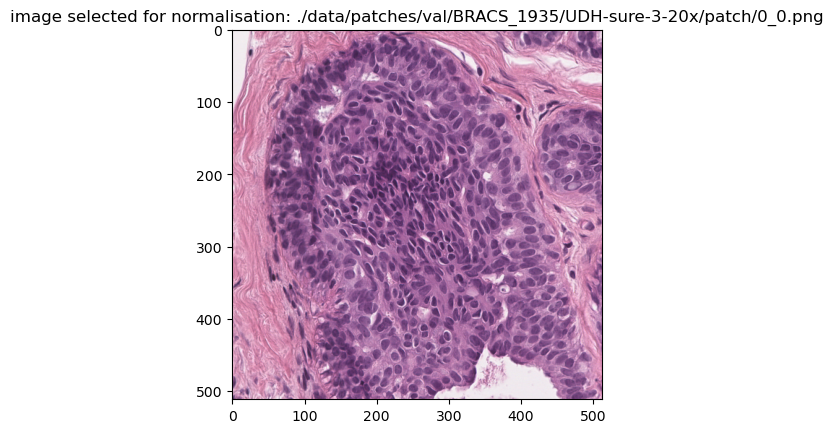

In [10]:
norm_img_path = val_img_path[len(val_img_path)//2]
norm_img_arr = cv2.cvtColor(cv2.imread(norm_img_path), cv2.COLOR_BGR2RGB)
plt.imshow(norm_img_arr)
plt.title(f"image selected for normalisation: {norm_img_path}")
plt.show()

In [11]:
stain_normaliser = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
stain_normaliser.fit(norm_img_arr)

In [12]:
patch_train_dataset = PatchDataset(
    train_img_path, train_mask_path, mode="RGB", name_to_class_mapping=CLASS_MAP,
    stain_normaliser=stain_normaliser,
    level="patch", transform=train_transform, seed=0
)

patch_val_dataset = PatchDataset(
    val_img_path, val_mask_path, mode="RGB", name_to_class_mapping=CLASS_MAP,
    stain_normaliser=stain_normaliser,
    level="patch", transform=val_transform, seed=0
)

In [13]:
num_classes = len(LABEL_MAP) + 1

In [14]:
# Scratch
model = torchvision.models.resnext50_32x4d(num_classes=num_classes)

# Transfer learning
# model = torchvision.models.resnext50_32x4d()
# model.load_state_dict(torch.load("./models/resnext50_32x4d-pretrained.pth"))
# num_ftrs = model.fc.in_features
# model.fc = torch.nn.Linear(num_ftrs, num_classes)

In [15]:
torch.cuda.empty_cache()
gc.collect()

3286

In [15]:
# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 16
EPOCHS = 100
NUM_WORKERS = 16
PREFETCH_FACTOR = 4

if __name__ == "__main__":
    

    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        patch_train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        patch_val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    
    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()

    set_name = f"resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}"
    
    def eval_fn(output:torch.Tensor, targets: torch.Tensor, num_classes):
        # calculate the accuracy
        output = torch.argmax(output, dim=1)
        acc = (output == targets).sum().item() / output.shape[0]
        return acc

    # train the network
    history = run_train_loop(
        model, 8, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, eval_fn, model_type="classification",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png")

100%|██████████| 754/754 [06:39<00:00,  1.89it/s]

train_utils - train_one_epoch - metrics: {'total_train_loss': 727.1458417475224, 'total_val_loss': 0, 'total_train_score': 420.1875, 'total_val_score': 0}


train_utils - evaluate_one_epoch - metrics: {'total_train_loss': 727.1458417475224, 'total_val_loss': 80.60361097753048, 'total_train_score': 420.1875, 'total_val_score': 38.3125}
2023-08-19 17:54:33,490-INFO-train_utils - Epoch 1/10
2023-08-19 17:54:33,491-INFO-Train Loss: 0.9644 Validation Loss: 1.2030
2023-08-19 17:54:33,491-INFO-Train Score: 0.5573 Validation Score: 0.5718


  0%|          | 0/754 [00:21<?, ?it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/malus/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_140434/1973060939.py", line 40, in <module>
    history = run_train_loop(
  File "/home/malus/UCL-HDS-Dissertation/train_utils.py", line 184, in run_train_loop
    # set the model in evaluation phase
  File "/home/malus/UCL-HDS-Dissertation/train_utils.py", line 56, in train_one_epoch
    model, num_classes, device, criterion,
  File "/home/malus/UCL-HDS-Dissertation/train_utils.py", line 40, in forward_step
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/malus/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/malus/anaconda3/envs/torch/li

In [16]:
model = torchvision.models.resnext50_32x4d(num_classes=num_classes)
model.load_state_dict(torch.load(f"./models/resnext_{COLOR_SPACE}_{'mixed' if MAGNIFICATION == '*' else MAGNIFICATION}_best_model.pth")["model_state_dict"])

<All keys matched successfully>

In [ ]:
model.to(device)

In [ ]:
# test model on validation set
test_img_paths = val_img_path[0:5000:500]
test_mask_paths = val_mask_path[0:5000:500]

print(val_img_path)

test_dataset = PatchDataset(
    test_img_paths, test_mask_paths, mode="RGB",
    name_to_class_mapping=CLASS_MAP,
    stain_normaliser=stain_normaliser,
    level="patch",
    transform=val_transform
)

test_loader = DataLoader(test_dataset, batch_size=10)

model.eval()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data
        target = target
        output = model(data)
        
        plt.figure(figsize=(20, 10))
        # plot the images
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.imshow(target[i].cpu().squeeze(), alpha=0.4)
            plt.axis("off")
            plt.title(f"Predicted: {torch.argmax(output, dim=1)[i]}, Ground Truth: {target[i]}")